<a href="https://colab.research.google.com/github/elianderlohr/muse-dlf/blob/main/notebooks/explainablity/slmuse-dlf-explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SLMuSE-DLF Explainability

Plot the explainability of the SLMuSE-DLF model. By using the dictionary learning approach it is (1.) possible to extract how different words in a certaim semantic role predict the presence of a document level frame and (2.) identify how the FrameAxis constallations are predicting the document level frames.

In [1]:
# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls /content/drive/MyDrive/Git/muse-dlf

assets		       category_lists_p.pkl  predicted_labels.npy  src		used_labels_a0.npy
category_lists_a0.pkl  data		     README.md		   tests	used_labels_a1.npy
category_lists_a1.pkl  model.md		     research-notebooks    ToDo.md	used_labels_p.npy
category_lists_fx.pkl  notebooks	     run		   used_fx.npy


In [4]:
!pip install wandb==0.17.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.0 MB/s eta 0:00:00


In [5]:
!pip install wandb==0.17.4 allennlp allennlp-models spacy

ERROR: Operation cancelled by user


In [5]:
!pip install torch==2.3.1

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [6]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 45.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [7]:
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 56.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.42.4
    Uninstalling transformers-4.42.4:
      Successfully uninstalled transformers-4.42.4


In [8]:
!pip install iterative-stratification

In [9]:
import sys
sys.path.append('/content/drive/MyDrive/Git/muse-dlf/src')

In [10]:
from preprocessing.pre_processor import PreProcessor
from preprocessing.datasets.article_dataset import custom_collate_fn
from model.muse_dlf.muse import MuSEDLF
from model.slmuse_dlf.muse import SLMuSEDLF

# import tokenizer for roberta fast
from transformers import RobertaTokenizerFast
import wandb
import inspect
import torch
import spacy
import pickle
from pathlib import Path
from torch.utils.data import DataLoader

In [11]:
wandb.require("core")

In [12]:
import nltk

In [13]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [15]:
base_path = "drive/MyDrive/Git/"

## Setup wandb

In [16]:
from google.colab import userdata

wandb.login(key=userdata.get('WANDB_API_KEY'))

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [17]:
run = wandb.init(project="slmuse-dlf", job_type="inference")

wandb: Currently logged in as: elias-anderlohr (elianderlohr). Use `wandb login --relogin` to force relogin


## Clean

In [19]:
def clean_gpu_memory():
    # Clear cache
    torch.cuda.empty_cache()
    # Reset peak memory stats
    torch.cuda.reset_peak_memory_stats()
    # Perform garbage collection
    import gc
    gc.collect()

clean_gpu_memory()

## Load SLMuSE-DLF

## Load Roberta Model

In [20]:
roberta_artifact = run.use_artifact('elianderlohr-org/wandb-registry-model/mfc-roberta-finetune:latest', type='model')
roberta_dir = roberta_artifact.download()

wandb: Downloading large artifact mfc-roberta-finetune:latest, 1427.32MB. 7 files... 
Done. 0:0:0.2


## Load Dataset

In [18]:
dataset_artifact = run.use_artifact('elianderlohr-org/wandb-registry-dataset/mfc-labeled:latest', type='dataset')
dataset_dir = dataset_artifact.download()

In [18]:
dataset_unsplit_artifact = run.use_artifact('elianderlohr-org/wandb-registry-dataset/mfc-labeled-unsplit:latest', type='dataset')
dataset_unsplit_dir = dataset_unsplit_artifact.download()

In [19]:
dataset_unsplit_dir

'/content/artifacts/mfc-dataset-unsplitted:v0'

In [20]:
!ls /content/artifacts/mfc-dataset-unsplitted:v0

dataset_artifact.pkl


## Load Model

In [21]:
import inspect
def load_model_from_wandb(name):
    model_artifact = run.use_artifact(name, type='model')
    model_dir = model_artifact.download()

    # Access the configuration
    config = model_artifact.metadata
    # Get the parameters of the SLMUSEDLF class constructor
    params = inspect.signature(SLMuSEDLF.__init__).parameters

    # Extract the relevant parameters from the config dictionary
    model_params = {key: config[key] for key in params if key in config}
    model_params["bert_model_name"] = "roberta-base"
    model_params["bert_model_name_or_path"] = roberta_dir
    # model_params["_debug"] = True

    model = SLMuSEDLF(**model_params)
    model.set_log_level("INFO")

    # Assuming you load the state_dict as follows
    state_dict = torch.load(f"{model_dir}/pytorch_model.bin", map_location="cuda")
    model.load_state_dict(state_dict)

    return model, config

name = 'elianderlohr/slmuse-dlf/eval_whipping_scooter_6311_model:v5'
# model, config = load_model_from_wandb(name)

In [22]:
model_name = name.split("/")[2].replace(":", "-")
model_name

'eval_whipping_scooter_6311_model-v5'

## Create Dataset

In [23]:
class_column_names = "Capacity and Resources;Crime and Punishment;Cultural Identity;Economic;External Regulation and Reputation;Fairness and Equality;Health and Safety;Legality, Constitutionality, Jurisdiction;Morality;Other;Policy Prescription and Evaluation;Political;Public Sentiment;Quality of Life;Security and Defense".split(";")

### Create Dataset

In [24]:
# Define paths to the dataset files within the downloaded directory
train_artifact_filepath = Path(dataset_dir) / 'train_dataset_artifact.pkl'
test_artifact_filepath = Path(dataset_dir) / 'test_dataset_artifact.pkl'

# Load the datasets from the artifact files
with train_artifact_filepath.open("rb") as f:
    loaded_train_dataset = pickle.load(f)

with test_artifact_filepath.open("rb") as f:
    loaded_test_dataset = pickle.load(f)

In [27]:
batch_size = 64 + 32

In [26]:
# create dataloaders
train_dataloader = DataLoader(
    loaded_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=custom_collate_fn,
    drop_last=True,
    pin_memory=True,
    num_workers=1,
)

test_dataloader = DataLoader(
    loaded_test_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=custom_collate_fn,
    drop_last=True,
    pin_memory=True,
    num_workers=1,
)

In [27]:
test_dataset = loaded_test_dataset
train_dataset = loaded_train_dataset

In [28]:
class TruncatedDataset:
    def __init__(self, original_dataset, new_length):
        self.original_dataset = original_dataset
        self.new_length = new_length

    def __getitem__(self, idx):
        return self.original_dataset[idx]

    def __len__(self):
        return self.new_length

def truncate_dataset(dataset, batch_size):
    dataset_length = len(dataset)
    truncated_length = (dataset_length // batch_size) * batch_size

    if isinstance(dataset, list):
        return dataset[:truncated_length]
    elif hasattr(dataset, '__getitem__') and hasattr(dataset, '__len__'):
        return TruncatedDataset(dataset, truncated_length)
    else:
        raise TypeError("Unsupported dataset type. Expected a list or a class with __getitem__ and __len__ methods.")

In [29]:
test_dataset = truncate_dataset(loaded_test_dataset, batch_size)
train_dataset = truncate_dataset(loaded_train_dataset, batch_size)

## Create Full dataset

In [24]:
# Define paths to the dataset files within the downloaded directory
unsplit_artifact_filepath = Path(dataset_unsplit_dir) / 'dataset_artifact.pkl'

# Load the datasets from the artifact files
with unsplit_artifact_filepath.open("rb") as f:
    loaded_unsplit_dataset = pickle.load(f)

In [25]:
unsplit_dataset = loaded_unsplit_dataset

In [28]:
unsplit_dataloader = DataLoader(
    unsplit_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=custom_collate_fn,
    drop_last=False,
    pin_memory=True,
    num_workers=1,
)

## Run model with data

In [33]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

True
0
Tesla T4


In [32]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [34]:
import torch
import numpy as np
from tqdm.notebook import tqdm

def predict_inspect(model, dataloader, device='cuda', return_labels=False):
    model = model.to(device)
    model.eval()

    num_sentences = 24
    max_args_per_sentence = 10
    K = 15
    fx_dim = 10  # Adjust this value if your fx_dim is different

    print(f"num_batches: {len(dataloader)}, num_sentences: {num_sentences}, "
          f"max_args_per_sentence: {max_args_per_sentence}, K: {K}, fx_dim: {fx_dim}")

    # Initialize lists to store results for each batch
    all_p_d, all_p_g = [], []
    all_a0_d, all_a0_g = [], []
    all_a1_d, all_a1_g = [], []
    all_fx_d, all_fx_g = [], []
    all_preds, all_raw_preds = [], []
    all_labels = [] if return_labels else None

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Processing Batches"):
            sentence_ids = batch['sentence_ids'].to(device)
            sentence_attention_masks = batch['sentence_attention_masks'].to(device)
            predicate_ids = batch['predicate_ids'].to(device)
            arg0_ids = batch['arg0_ids'].to(device)
            arg1_ids = batch['arg1_ids'].to(device)
            frameaxis_data = batch['frameaxis'].to(device)

            if return_labels:
                labels = batch['labels']

            batch_size = sentence_ids.shape[0]

            sentence_embeddings, predicate_embeddings, arg0_embeddings, arg1_embeddings = model.aggregation(
                sentence_ids, sentence_attention_masks, predicate_ids, arg0_ids, arg1_ids
            )

            batch_p_d = torch.zeros(batch_size, num_sentences, max_args_per_sentence, K, device=device)
            batch_p_g = torch.zeros(batch_size, num_sentences, max_args_per_sentence, K, device=device)
            batch_a0_d = torch.zeros(batch_size, num_sentences, max_args_per_sentence, K, device=device)
            batch_a0_g = torch.zeros(batch_size, num_sentences, max_args_per_sentence, K, device=device)
            batch_a1_d = torch.zeros(batch_size, num_sentences, max_args_per_sentence, K, device=device)
            batch_a1_g = torch.zeros(batch_size, num_sentences, max_args_per_sentence, K, device=device)
            batch_fx_d = torch.zeros(batch_size, num_sentences, K, device=device)
            batch_fx_g = torch.zeros(batch_size, num_sentences, K, device=device)

            for sentence_idx in range(num_sentences):
                s_sentence_span = sentence_embeddings[:, sentence_idx, :]
                v_fx = frameaxis_data[:, sentence_idx, :]

                for span_idx in range(max_args_per_sentence):
                    v_p_span = predicate_embeddings[:, sentence_idx, span_idx, :]
                    v_a0_span = arg0_embeddings[:, sentence_idx, span_idx, :]
                    v_a1_span = arg1_embeddings[:, sentence_idx, span_idx, :]

                    mask_p = (v_p_span.abs().sum(dim=-1) != 0).float().bool()
                    mask_a0 = (v_a0_span.abs().sum(dim=-1) != 0).float().bool()
                    mask_a1 = (v_a1_span.abs().sum(dim=-1) != 0).float().bool()

                    output = model.unsupervised.combined_autoencoder(
                        v_p_span, v_a0_span, v_a1_span, mask_p, mask_a0, mask_a1, s_sentence_span, 0.6
                    )

                    batch_p_d[:, sentence_idx, span_idx, :] = output["p"]["d"]
                    batch_p_g[:, sentence_idx, span_idx, :] = output["p"]["g"]
                    batch_a0_d[:, sentence_idx, span_idx, :] = output["a0"]["d"]
                    batch_a0_g[:, sentence_idx, span_idx, :] = output["a0"]["g"]
                    batch_a1_d[:, sentence_idx, span_idx, :] = output["a1"]["d"]
                    batch_a1_g[:, sentence_idx, span_idx, :] = output["a1"]["g"]

                mask_fx = (v_fx.abs().sum(dim=-1) != 0).float().bool()
                frameaxis_output = model.unsupervised_fx.frameaxis_autoencoder(v_fx, mask_fx, s_sentence_span, 0.6)

                batch_fx_d[:, sentence_idx, :] = frameaxis_output["d"]
                batch_fx_g[:, sentence_idx, :] = frameaxis_output["g"]

            outputs = model(
                sentence_ids, sentence_attention_masks, predicate_ids, arg0_ids, arg1_ids, frameaxis_data, 0.5
            )

            supervised_logits = outputs["supervised_logits"]
            raw_predictions = torch.softmax(supervised_logits, dim=-1)
            thresholded_predictions = (raw_predictions > 0.5).long()

            # Append batch results to lists
            all_p_d.append(batch_p_d.cpu())
            all_p_g.append(batch_p_g.cpu())
            all_a0_d.append(batch_a0_d.cpu())
            all_a0_g.append(batch_a0_g.cpu())
            all_a1_d.append(batch_a1_d.cpu())
            all_a1_g.append(batch_a1_g.cpu())
            all_fx_d.append(batch_fx_d.cpu())
            all_fx_g.append(batch_fx_g.cpu())
            all_preds.append(thresholded_predictions.cpu())
            all_raw_preds.append(raw_predictions.cpu())

            if return_labels:
                all_labels.append(labels)

    # Concatenate results from all batches
    all_p_d = torch.cat(all_p_d, dim=0).numpy()
    all_p_g = torch.cat(all_p_g, dim=0).numpy()
    all_a0_d = torch.cat(all_a0_d, dim=0).numpy()
    all_a0_g = torch.cat(all_a0_g, dim=0).numpy()
    all_a1_d = torch.cat(all_a1_d, dim=0).numpy()
    all_a1_g = torch.cat(all_a1_g, dim=0).numpy()
    all_fx_d = torch.cat(all_fx_d, dim=0).numpy()
    all_fx_g = torch.cat(all_fx_g, dim=0).numpy()
    predictions = torch.cat(all_preds, dim=0).numpy()
    raw_predictions = torch.cat(all_raw_preds, dim=0).numpy()

    if return_labels:
        all_labels = torch.cat(all_labels, dim=0).numpy()

    print("Final shapes:")
    print(f"all_p_d shape: {all_p_d.shape}")
    print(f"all_p_g shape: {all_p_g.shape}")
    print(f"all_a0_d shape: {all_a0_d.shape}")
    print(f"all_a0_g shape: {all_a0_g.shape}")
    print(f"all_a1_d shape: {all_a1_d.shape}")
    print(f"all_a1_g shape: {all_a1_g.shape}")
    print(f"all_fx_d shape: {all_fx_d.shape}")
    print(f"all_fx_g shape: {all_fx_g.shape}")
    print(f"predictions shape: {predictions.shape}")
    print(f"raw_predictions shape: {raw_predictions.shape}")

    if return_labels:
        return (predictions, raw_predictions, all_labels,
                all_p_d, all_p_g, all_a0_d, all_a0_g, all_a1_d, all_a1_g, all_fx_d, all_fx_g)
    else:
        return (predictions, raw_predictions,
                all_p_d, all_p_g, all_a0_d, all_a0_g, all_a1_d, all_a1_g, all_fx_d, all_fx_g)

In [35]:
clean_gpu_memory()

In [36]:
env = "unsplit"

output = predict_inspect(model, unsplit_dataloader, device="cuda", return_labels=False)

(predicted_labels,
 raw_predictions,
  used_labels_p_d, used_labels_p_g,
  used_labels_a0_d, used_labels_a0_g,
  used_labels_a1_d, used_labels_a1_g,
  used_fx_d, used_fx_g) = output

np.savez(base_path + f'/muse-dlf/data/explainability/mfc/output_{model_name}_{env}_slmuse-dlf-model.npz',
         predicted_labels=predicted_labels,
         raw_predictions=raw_predictions,
         used_labels_p_d=used_labels_p_d,
         used_labels_p_g=used_labels_p_g,
         used_labels_a0_d=used_labels_a0_d,
         used_labels_a0_g=used_labels_a0_g,
         used_labels_a1_d=used_labels_a1_d,
         used_labels_a1_g=used_labels_a1_g,
         used_fx_d=used_fx_d,
         used_fx_g=used_fx_g)

num_batches: 62, num_sentences: 24, max_args_per_sentence: 10, K: 15, fx_dim: 10


Processing Batches:   0%|          | 0/62 [00:00<?, ?it/s]

Final shapes:
all_p_d shape: (5932, 24, 10, 15)
all_p_g shape: (5932, 24, 10, 15)
all_a0_d shape: (5932, 24, 10, 15)
all_a0_g shape: (5932, 24, 10, 15)
all_a1_d shape: (5932, 24, 10, 15)
all_a1_g shape: (5932, 24, 10, 15)
all_fx_d shape: (5932, 24, 15)
all_fx_g shape: (5932, 24, 15)
predictions shape: (5932, 15)
raw_predictions shape: (5932, 15)


## Evaluate Predictions

### Extract Semantic Roles

In [29]:
import numpy as np

def load_environment_specific_labels(base_path, model_name):
    environments = ['unsplit']
    used_labels = {}

    for env in environments:
        file_path = f'{base_path}/muse-dlf/data/explainability/mfc/output_{model_name}_{env}_slmuse-dlf-model.npz'
        loaded_arrays = np.load(file_path)

        used_labels[f'{env}_predicted_labels'] = loaded_arrays['predicted_labels']
        used_labels[f'{env}_raw_predictions'] = loaded_arrays['raw_predictions']
        used_labels[f'{env}_used_labels_p_g'] = loaded_arrays['used_labels_p_g']
        used_labels[f'{env}_used_labels_p_d'] = loaded_arrays['used_labels_p_d']
        used_labels[f'{env}_used_labels_a0_g'] = loaded_arrays['used_labels_a0_g']
        used_labels[f'{env}_used_labels_a0_d'] = loaded_arrays['used_labels_a0_d']
        used_labels[f'{env}_used_labels_a1_g'] = loaded_arrays['used_labels_a1_g']
        used_labels[f'{env}_used_labels_a1_d'] = loaded_arrays['used_labels_a1_d']
        used_labels[f'{env}_used_fx_g'] = loaded_arrays['used_fx_g']
        used_labels[f'{env}_used_fx_d'] = loaded_arrays['used_fx_d']

    return used_labels

used_labels = load_environment_specific_labels(base_path, model_name)

unsplit_predicted_labels = used_labels['unsplit_predicted_labels']
unsplit_raw_predictions = used_labels['unsplit_raw_predictions']
unsplit_used_labels_p_g = used_labels['unsplit_used_labels_p_g']
unsplit_used_labels_p_d = used_labels['unsplit_used_labels_p_d']
unsplit_used_labels_a0_g = used_labels['unsplit_used_labels_a0_g']
unsplit_used_labels_a0_d = used_labels['unsplit_used_labels_a0_d']
unsplit_used_labels_a1_g = used_labels['unsplit_used_labels_a1_g']
unsplit_used_labels_a1_d = used_labels['unsplit_used_labels_a1_d']
unsplit_used_fx_g = used_labels['unsplit_used_fx_g']
unsplit_used_fx_d = used_labels['unsplit_used_fx_d']

In [30]:
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm.notebook import tqdm

def process_batch(batch_index, dataset, used_labels_p_g, used_labels_arg0_g, used_labels_arg1_g, used_labels_fx_g, threshold):
    result = {
        "predicate": {name: [] for name in class_column_names},
        "arg0": {name: [] for name in class_column_names},
        "arg1": {name: [] for name in class_column_names},
        "fx": {name: [] for name in class_column_names}
    }

    batch_data = dataset[batch_index]

    for arg_type, used_labels in zip(["predicate", "arg0", "arg1"],
                                     [used_labels_p_g, used_labels_arg0_g, used_labels_arg1_g]):
        mask = used_labels[batch_index] > threshold
        active_classes = np.where(mask)

        for sentence_idx, arg_idx, class_idx in zip(*active_classes):
            tokens = batch_data[f"{arg_type}_ids"][sentence_idx, arg_idx]
            class_name = class_column_names[class_idx]
            result[arg_type][class_name].append(tokens)

    # Process frameaxis
    fx_mask = used_labels_fx_g[batch_index] > threshold
    fx_active_classes = np.where(fx_mask)

    for sentence_idx, class_idx in zip(*fx_active_classes):
        float_values = batch_data["frameaxis"][sentence_idx]
        class_name = class_column_names[class_idx]
        result["fx"][class_name].append(float_values)

    return result

def analyze_data(dataset, used_labels_p_g, used_labels_arg0_g, used_labels_arg1_g, used_labels_fx_g, threshold):
    num_batches = len(dataset)

    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(process_batch, i, dataset, used_labels_p_g, used_labels_arg0_g,
                                   used_labels_arg1_g, used_labels_fx_g, threshold)
                   for i in range(num_batches)]

        results = []
        for future in tqdm(as_completed(futures), total=num_batches, desc="Processing batches"):
            results.append(future.result())

    combined_results = {
        "predicate": {name: [] for name in results[0]["predicate"]},
        "arg0": {name: [] for name in results[0]["arg0"]},
        "arg1": {name: [] for name in results[0]["arg1"]},
        "fx": {name: [] for name in results[0]["fx"]}
    }

    for result in tqdm(results, desc="Combining results"):
        for arg_type in ["predicate", "arg0", "arg1", "fx"]:
            for class_name, values in result[arg_type].items():
                combined_results[arg_type][class_name].extend(values)

    return combined_results

In [31]:
category_lists = analyze_data(unsplit_dataset, unsplit_used_labels_p_g, unsplit_used_labels_a0_g, unsplit_used_labels_a1_g, unsplit_used_fx_g, threshold = 0.8)
combined_results = category_lists

Processing batches:   0%|          | 0/5932 [00:00<?, ?it/s]

Combining results:   0%|          | 0/5932 [00:00<?, ?it/s]

In [100]:
import os
import pickle
from datetime import datetime

def save_combined_results(combined_results, base_path, model_name):
    #save_dir = os.path.join()
    #os.makedirs(save_dir, exist_ok=True)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f'output_{model_name}_combined_{timestamp}.pkl'
    full_path = os.path.join(filename)

    with open(full_path, 'wb') as f:
        pickle.dump(combined_results, f)

    print(f"Combined results saved to: {full_path}")
    return full_path

def load_combined_results(file_path):
    with open(file_path, 'rb') as f:
        combined_results = pickle.load(f)

    print(f"Combined results loaded from: {file_path}")
    return combined_results

In [101]:
save_combined_results(combined_results, base_path, model_name)

Combined results saved to: output_eval_whipping_scooter_6311_model-v5_combined_20240817_144938.pkl


'output_eval_whipping_scooter_6311_model-v5_combined_20240817_144938.pkl'

In [32]:
combined_results = load_combined_results(base_path + "/muse-dlf/data/explainability/mfc/output_eval_whipping_scooter_6311_model-v5_combined_20240817_003949.pkl")

Combined results loaded from: drive/MyDrive/Git//muse-dlf/data/explainability/mfc/output_eval_whipping_scooter_6311_model-v5_combined_20240817_003949.pkl


In [34]:
category_lists_p = combined_results["predicate"]
category_lists_a0 = combined_results["arg0"]
category_lists_a1 = combined_results["arg1"]
category_lists_fx = combined_results["fx"]

In [35]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tqdm.notebook import tqdm
import numpy as np
import torch

# Ensure you have downloaded the necessary NLTK resources
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

def decode_tokens(token_dict, tokenizer, remove_stopwords=False, lemmatize=False):
    decoded_data = {}
    stop_words = set(stopwords.words('english')) if remove_stopwords else set()
    lemmatizer = WordNetLemmatizer() if lemmatize else None

    for category, token_lists in token_dict.items():
        decoded_data[category] = []
        for tokens in tqdm(token_lists, desc=f"Decoding {category}", leave=False):
            # Convert tokens to a list if it's a tensor or numpy array
            if isinstance(tokens, torch.Tensor):
                tokens = tokens.cpu().numpy()
            if isinstance(tokens, np.ndarray):
                tokens = tokens.tolist()

            # Skip if all tokens are 1 or the list is empty
            if not tokens or all(t == 1 for t in tokens):
                continue

            # Ensure tokens are integers and filter out padding (1) and special tokens (usually 0, 2, 3)
            tokens = [int(t) for t in tokens if t > 3]

            if tokens:  # Check again after filtering
                # Decode the tokens
                decoded_text = tokenizer.decode(tokens, skip_special_tokens=True).strip()

                # Remove non-alphabetic characters (but keep spaces)
                decoded_text = re.sub(r'[^A-Za-z ]', '', decoded_text)

                # Tokenize, optionally lemmatize, and remove stop words
                words = word_tokenize(decoded_text)
                processed_words = [lemmatizer.lemmatize(word.lower()) if lemmatizer else word.lower() for word in words if word.lower() not in stop_words]

                # Join the words back into a string and ensure it's not empty
                processed_text = ' '.join(processed_words)
                if processed_text:
                    decoded_data[category].append(processed_text)

    return decoded_data

# Usage example:
# Decode the token IDs for each ARG with a progress bar for the entire process
with tqdm(total=3, desc="Decoding ARGs") as pbar:
    decoded_predicate = decode_tokens(category_lists_p, tokenizer, remove_stopwords=True, lemmatize=True)
    pbar.update(1)
    decoded_arg0 = decode_tokens(category_lists_a0, tokenizer, remove_stopwords=True, lemmatize=True)
    pbar.update(1)
    decoded_arg1 = decode_tokens(category_lists_a1, tokenizer, remove_stopwords=True, lemmatize=True)
    pbar.update(1)

Decoding ARGs:   0%|          | 0/3 [00:00<?, ?it/s]

Decoding Capacity and Resources:   0%|          | 0/3452 [00:00<?, ?it/s]

Decoding Crime and Punishment:   0%|          | 0/4953 [00:00<?, ?it/s]

Decoding Cultural Identity:   0%|          | 0/4045 [00:00<?, ?it/s]

Decoding Economic:   0%|          | 0/4327 [00:00<?, ?it/s]

Decoding External Regulation and Reputation:   0%|          | 0/3372 [00:00<?, ?it/s]

Decoding Fairness and Equality:   0%|          | 0/3450 [00:00<?, ?it/s]

Decoding Health and Safety:   0%|          | 0/3347 [00:00<?, ?it/s]

Decoding Legality, Constitutionality, Jurisdiction:   0%|          | 0/4418 [00:00<?, ?it/s]

Decoding Morality:   0%|          | 0/3360 [00:00<?, ?it/s]

Decoding Other:   0%|          | 0/3369 [00:00<?, ?it/s]

Decoding Policy Prescription and Evaluation:   0%|          | 0/3345 [00:00<?, ?it/s]

Decoding Political:   0%|          | 0/4565 [00:00<?, ?it/s]

Decoding Public Sentiment:   0%|          | 0/3460 [00:00<?, ?it/s]

Decoding Quality of Life:   0%|          | 0/4842 [00:00<?, ?it/s]

Decoding Security and Defense:   0%|          | 0/3489 [00:00<?, ?it/s]

Decoding Capacity and Resources:   0%|          | 0/2080 [00:00<?, ?it/s]

Decoding Crime and Punishment:   0%|          | 0/2850 [00:00<?, ?it/s]

Decoding Cultural Identity:   0%|          | 0/2536 [00:00<?, ?it/s]

Decoding Economic:   0%|          | 0/2768 [00:00<?, ?it/s]

Decoding External Regulation and Reputation:   0%|          | 0/2129 [00:00<?, ?it/s]

Decoding Fairness and Equality:   0%|          | 0/2067 [00:00<?, ?it/s]

Decoding Health and Safety:   0%|          | 0/2074 [00:00<?, ?it/s]

Decoding Legality, Constitutionality, Jurisdiction:   0%|          | 0/2594 [00:00<?, ?it/s]

Decoding Morality:   0%|          | 0/2080 [00:00<?, ?it/s]

Decoding Other:   0%|          | 0/2088 [00:00<?, ?it/s]

Decoding Policy Prescription and Evaluation:   0%|          | 0/2030 [00:00<?, ?it/s]

Decoding Political:   0%|          | 0/2832 [00:00<?, ?it/s]

Decoding Public Sentiment:   0%|          | 0/2037 [00:00<?, ?it/s]

Decoding Quality of Life:   0%|          | 0/2841 [00:00<?, ?it/s]

Decoding Security and Defense:   0%|          | 0/2033 [00:00<?, ?it/s]

Decoding Capacity and Resources:   0%|          | 0/3132 [00:00<?, ?it/s]

Decoding Crime and Punishment:   0%|          | 0/4218 [00:00<?, ?it/s]

Decoding Cultural Identity:   0%|          | 0/3845 [00:00<?, ?it/s]

Decoding Economic:   0%|          | 0/4123 [00:00<?, ?it/s]

Decoding External Regulation and Reputation:   0%|          | 0/3143 [00:00<?, ?it/s]

Decoding Fairness and Equality:   0%|          | 0/3097 [00:00<?, ?it/s]

Decoding Health and Safety:   0%|          | 0/3322 [00:00<?, ?it/s]

Decoding Legality, Constitutionality, Jurisdiction:   0%|          | 0/4050 [00:00<?, ?it/s]

Decoding Morality:   0%|          | 0/3158 [00:00<?, ?it/s]

Decoding Other:   0%|          | 0/3195 [00:00<?, ?it/s]

Decoding Policy Prescription and Evaluation:   0%|          | 0/3600 [00:00<?, ?it/s]

Decoding Political:   0%|          | 0/4150 [00:00<?, ?it/s]

Decoding Public Sentiment:   0%|          | 0/3102 [00:00<?, ?it/s]

Decoding Quality of Life:   0%|          | 0/4287 [00:00<?, ?it/s]

Decoding Security and Defense:   0%|          | 0/3274 [00:00<?, ?it/s]

In [36]:
# count words
def count_word(decoded_dict, word_to_count, exact=True):
  print(f"Trying to count: {word_to_count}")

  for key in decoded_dict.keys():
    counter = 0
    for word in decoded_dict[key]:

      if exact:
        if word.lower() == word_to_count.lower():
          counter += 1
      else:
        if word_to_count.lower() in word.lower():
          counter += 1

    print(f"{key}: {counter}")

In [37]:
count_word(decoded_predicate, "cost")

Trying to count: cost
Capacity and Resources: 1
Crime and Punishment: 2
Cultural Identity: 1
Economic: 4
External Regulation and Reputation: 2
Fairness and Equality: 1
Health and Safety: 2
Legality, Constitutionality, Jurisdiction: 1
Morality: 0
Other: 2
Policy Prescription and Evaluation: 2
Political: 4
Public Sentiment: 2
Quality of Life: 1
Security and Defense: 2


In [41]:
import math
from collections import Counter
from tqdm.notebook import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)

def get_enhanced_stopwords():
    """
    Get an enhanced set of stopwords combining NLTK's stopwords and custom additions.
    """
    nltk_stopwords = set(stopwords.words('english'))

    custom_stopwords = {
        "said", "say", "see", "one", "u", "ama", "told", "hear", "get", "make", "know",
        "go", "come", "take", "give", "use", "find", "want", "look",
        "can", "could", "may", "might", "shall", "should", "will", "would", "must",
        "it", "they", "we", "he", "she", "you", "them", "him", "her",
        "good", "new", "first", "last", "long", "great", "little", "own", "other", "old", "right", "big", "high", "different",
        "so", "just", "now", "then", "also", "very",
        "in", "on", "at", "by", "for", "with", "about",
        "a", "an", "the",
        "and", "but", "or", "as", "if", "when"
    }

    return nltk_stopwords.union(custom_stopwords)

def extract_frame_descriptors(data_dict, min_frequency=5, top_n=20, additional_stopwords=[], term_combinations={}):
    """
    Extract meaningful descriptors for each frame based on their frequency and distinctiveness.

    :param data_dict: Dictionary with frames as keys and lists of words as values
    :param min_frequency: Minimum frequency of a word within a frame to be considered
    :param top_n: Number of top descriptors to return for each frame
    :param additional_stopwords: List of additional stopwords to remove
    :param term_combinations: Dictionary of terms to combine, e.g., {'trump': ['trump', 'president trump']}
    :return: Dictionary with frames as keys and lists of (word, score) tuples as values
    """
    lemmatizer = WordNetLemmatizer()
    stop_words = get_enhanced_stopwords()
    stop_words.update(additional_stopwords)

    # Process words: lemmatize, remove stopwords, and combine terms
    def process_word(word):
        word = lemmatizer.lemmatize(word.lower())
        if word not in stop_words:
            for main_term, variations in term_combinations.items():
                if word in variations:
                    return main_term
            return word
        return None

    processed_data = {
        frame: [processed_word for word in nltk.word_tokenize(' '.join(words)) if (processed_word := process_word(word)) is not None]
        for frame, words in data_dict.items()
    }

    # Calculate overall word frequencies across all frames
    all_words = [word for words in processed_data.values() for word in words]
    overall_freq = Counter(all_words)

    # Calculate word frequencies for each frame
    frame_freq = {frame: Counter(words) for frame, words in processed_data.items()}

    # Calculate distinctiveness scores
    frame_descriptors = {}
    for frame, word_freq in tqdm(frame_freq.items(), desc="Extracting frame descriptors"):
        scores = {}
        for word, freq in word_freq.items():
            if freq >= min_frequency:
                # Calculate the distinctiveness score
                # Higher score means the word is more frequent in this frame compared to others
                distinctiveness = freq / overall_freq[word]
                # Multiply by log(freq) to give some weight to overall frequency
                scores[word] = distinctiveness * math.log(freq + 1)

        # Sort words by score and get top N
        top_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
        frame_descriptors[frame] = top_words

    return frame_descriptors

# Example usage
additional_stop_words = ["think", "used", "continued", "gotten", "getting", "become", "became", "like", "major", "despite", "including", "beyond"]  # Add any specific additional stopwords here
term_combinations = {
    'trump': ['trump', 'president trump'],
    'usa': ['usa', 'united states', 'united states of america'],
    # Add more combinations as needed
}

min_frequency=8

# Extract descriptors for each semantic role
with tqdm(total=3, desc="Extracting descriptors for all arguments") as pbar:
    descriptors_predicate = extract_frame_descriptors(decoded_predicate, min_frequency=min_frequency, additional_stopwords=additional_stop_words, term_combinations=term_combinations)
    pbar.update(1)
    descriptors_arg0 = extract_frame_descriptors(decoded_arg0, min_frequency=min_frequency,additional_stopwords=additional_stop_words, term_combinations=term_combinations)
    pbar.update(1)
    descriptors_arg1 = extract_frame_descriptors(decoded_arg1,min_frequency=min_frequency, additional_stopwords=additional_stop_words, term_combinations=term_combinations)
    pbar.update(1)

Extracting descriptors for all arguments:   0%|          | 0/3 [00:00<?, ?it/s]

Extracting frame descriptors:   0%|          | 0/15 [00:00<?, ?it/s]

Extracting frame descriptors:   0%|          | 0/15 [00:00<?, ?it/s]

Extracting frame descriptors:   0%|          | 0/15 [00:00<?, ?it/s]

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

def visualize_frame_descriptors(descriptors_predicate, descriptors_arg0, descriptors_arg1, word_limit=10):
    # Initialize a list to collect DataFrame rows
    rows = []

    # Get all unique frames
    all_frames = set(descriptors_predicate.keys()) | set(descriptors_arg0.keys()) | set(descriptors_arg1.keys())

    # Populate the list with rows
    for frame in tqdm(all_frames, desc="Processing frames"):
        # Get the top N words and their scores
        pred_words = ', '.join([f"{word}" for word, score in descriptors_predicate.get(frame, [])[:word_limit]])
        arg0_words = ', '.join([f"{word}" for word, score in descriptors_arg0.get(frame, [])[:word_limit]])
        arg1_words = ', '.join([f"{word}" for word, score in descriptors_arg1.get(frame, [])[:word_limit]])

        # Create a dictionary for the row
        row = {
            "Frame": frame,
            "Predicate": pred_words,
            "ARG0": arg0_words,
            "ARG1": arg1_words
        }

        # Append the row dictionary to the rows list
        rows.append(row)

    # Convert the list of rows to a DataFrame
    df_full_table = pd.DataFrame(rows)

    return df_full_table

# Example usage
word_limit = 10
df_full_table = visualize_frame_descriptors(descriptors_predicate, descriptors_arg0, descriptors_arg1, word_limit)

df_full_table

Processing frames:   0%|          | 0/15 [00:00<?, ?it/s]

,Frame,Predicate,ARG0,ARG1
0,Quality of Life,"flee, introduced, created, sponsored, gave, en...","family, father, refugee, young, four, mr, pare...","family, child, wife, school, better, life, mot..."
1,Other,"help, proposed, leave, turned, led, called, en...","latino, jose, another, bush, order, state, imm...","demand, republican, number, welfare, federal, ..."
2,Crime and Punishment,"convicted, identify, target, threatened, serve...","agent, police, team, authority, patrol, custom...","gang, car, individual, released, two, detainee..."
3,Economic,"hire, intended, hiring, pay, consider, provide...","bank, grower, employer, company, job, worker, ...","labor, worker, tuition, economic, job, cost, b..."
4,External Regulation and Reputation,"apply, worked, put, needed, seen, done, receiv...","atlanta, hispanic, public, san, immigrant, two...","domestic, couple, construction, guard, made, i..."
5,Policy Prescription and Evaluation,"report, left, charged, stop, mean, called, ask...","provision, officer, illegal, country, resident...","system, benefit, immigrant, law, immigration, ..."
6,Fairness and Equality,"died, came, deported, issued, set, face, bring...","chairman, security, law, two, several, preside...","road, black, trying, site, similar, employee, ..."
7,"Legality, Constitutionality, Jurisdiction","ruled, refused, denied, bar, undocumented, req...","judge, court, barack, law, civil, living, stat...","hearing, basis, removal, order, notice, ruling..."
8,Security and Defense,"help, arrested, passed, feel, signed, forced, ...","human, city, mr, president, immigrant, worker,...","border, hope, whether, way, immigration, secur..."
9,Capacity and Resources,"speak, coming, reported, convicted, allows, ca...","child, yearold, student, immigrant, year, fede...","campaign, washington, door, noncitizen, immigr..."


### Evaluate Single Article

#### Code

In [48]:
import torch
import torch.nn.functional as F
import numpy as np

def evaluate_article(dataset, article_id, used_labels_p_d, used_labels_a0_d, used_labels_a1_d, used_fx_d, threshold_spans = 0.2):
    ds = dataset[article_id]

    results = {}
    results_array = []

    def get_span_data(predictions, values, span_idx, threshold):
        above_threshold = predictions > threshold
        if np.any(above_threshold):
            result = []
            for idx, (pred, value) in enumerate(zip(predictions, values)):
                if pred > threshold:
                    result.append({
                        "ids": values.tolist(),
                        "prob": float(pred),
                        "label_id": idx,
                        "span_idx": span_idx
                    })
            return result
        return None

    sent_len = len(ds["predicate_ids"])
    for sentence_idx in range(sent_len):
        sentence_data = {
            "sentence_ids": ds["sentence_ids"][sentence_idx].tolist(),
            "predicates": [],
            "arg0": [],
            "arg1": [],
            "fx": []
        }

        span_len = len(ds["predicate_ids"][sentence_idx])
        for span_idx in range(span_len):

            # Process predicates
            p = np.array(used_labels_p_d[article_id][sentence_idx][span_idx])
            ds_p_value = ds["predicate_ids"][sentence_idx][span_idx].int().numpy()
            span_data = get_span_data(p, ds_p_value, span_idx, threshold_spans)
            if span_data:
                sentence_data["predicates"].extend(span_data)

            # Process arg0
            a0 = np.array(used_labels_a0_d[article_id][sentence_idx][span_idx])
            ds_a0_value = ds["arg0_ids"][sentence_idx][span_idx].int().numpy()
            span_data = get_span_data(a0, ds_a0_value, span_idx, threshold_spans)
            if span_data:
                sentence_data["arg0"].extend(span_data)

            # Process arg1
            a1 = np.array(used_labels_a1_d[article_id][sentence_idx][span_idx])
            ds_a1_value = ds["arg1_ids"][sentence_idx][span_idx].int().numpy()
            span_data = get_span_data(a1, ds_a1_value, span_idx, threshold_spans)
            if span_data:
                sentence_data["arg1"].extend(span_data)

        # Process fx (frame axis)
        fx = np.array(used_fx_d[article_id][sentence_idx])

        ds_fx_value = ds["frameaxis"][sentence_idx].float().numpy()

        span_data = get_span_data(fx, ds_fx_value, sentence_idx, threshold_spans)
        if span_data:
            sentence_data["fx"].extend(span_data)

        results_array.append(sentence_data)

    results["sentences"] = results_array

    # Add label probabilities
    label_probs = unsplit_raw_predictions[article_id]
    results["label_probabilities"] = label_probs.tolist()

    # Keep the existing labels field for backward compatibility
    results["label"] = np.argmax(label_probs)

    return results

In [49]:
from IPython.core.display import display, HTML
import matplotlib.colors as mcolors
import random

# Function to generate a color palette based on the number of classes
def generate_colors(num_classes):
    base_colors = list(mcolors.TABLEAU_COLORS.values())
    if num_classes <= len(base_colors):
        return base_colors[:num_classes]
    else:
        additional_colors = random.sample(list(mcolors.CSS4_COLORS.values()), num_classes - len(base_colors))
        return base_colors + additional_colors

# Function to adjust color lightness based on probability
def adjust_color_lightness(color, prob):
    rgba = mcolors.to_rgba(color)
    new_color = (rgba[0], rgba[1], rgba[2], prob)  # Adjust the alpha channel based on the probability
    return mcolors.to_hex(new_color, keep_alpha=True)

# Function to create a linear gradient CSS string from a list of colors
def create_gradient(colors):
    color_stops = ', '.join([f'{color} {100*i/(len(colors)-1)}%' for i, color in enumerate(colors)])
    return f'linear-gradient(to right, {color_stops})'

# Function to create a tooltip string with all annotations for a word
# Function to create a tooltip string with all annotations for a word
def create_tooltip(annotations, class_column_names):
    tooltip_items = []
    for word, label, span_idx, color, prob, label_id in annotations:
        class_name = class_column_names[label_id]
        tooltip_items.append(f"{class_name} ({label}{span_idx}): {prob:.2f}")
    return '\\n'.join(tooltip_items)

# Function to generate HTML for SRL results
def generate_html_srl(article_results, class_column_names, tokenizer, ignore_helper_tokens=True, show_probabilities=True, only_highest_prob=False):
    used_classes = set()

    # First pass to collect used classes
    for sentence_data in article_results['sentences']:
        for annotation in sentence_data['predicates'] + sentence_data['arg0'] + sentence_data['arg1']:
            used_classes.add(annotation['label_id'])

    # add classes of article predictions
    used_classes.add(article_results['label'])

    used_classes = sorted(used_classes)
    num_classes = len(used_classes)
    colors = generate_colors(num_classes)
    class_to_color = {class_id: colors[i] for i, class_id in enumerate(used_classes)}

    html_content = '<span style="font-family: Arial, sans-serif; line-height: 1.5;">'

    # Add the predicted class labels
    html_content += '<h2>Predicted Classes:</h2>'
    label_index = article_results['label']
    label_name = class_column_names[label_index]
    html_content += f'<p><span style="display:inline-block; width:10px; height:10px; background-color: {class_to_color[label_index]}; margin-right:5px;"></span> {label_name}</p>'

    # Add legend
    html_content += '<div><strong>Legend:</strong><br>'
    for class_id in used_classes:
        class_name = class_column_names[class_id]

        color = class_to_color[class_id]
        html_content += f'<span style="display:inline-block; width:10px; height:10px; background-color: {color}; margin-right:5px;"></span> {class_name}<br>'
    html_content += '</div><br>'

    for sentence_data in article_results['sentences']:
        sentence_ids = sentence_data['sentence_ids']

        # Remove helper tokens if specified
        if ignore_helper_tokens:
            sentence_ids = [id for id in sentence_ids if id not in [0, 1, 2, 3]]  # assuming these are the IDs for <pad>, <cls>, <sep>, etc.

        sentence_text = tokenizer.decode(sentence_ids)
        words = sentence_text.split()

        annotated_text = words[:]  # create a copy of the words list

        annotations_map = {}

        def add_annotations(annotations, label):
            for annotation in annotations:
                ids = annotation['ids']
                prob = annotation['prob']
                span_idx = annotation['span_idx']
                label_id = annotation['label_id']
                color = adjust_color_lightness(class_to_color[label_id], prob)
                for i, word in enumerate(words):
                    if sentence_ids[i] in ids:
                        if i not in annotations_map:
                            annotations_map[i] = []
                        annotations_map[i].append((word, label, span_idx, color, prob, label_id))

        add_annotations(sentence_data['predicates'], 'p')
        add_annotations(sentence_data['arg0'], 'a')
        add_annotations(sentence_data['arg1'], 't')

        # Generate HTML for words with annotations
        for i, word in enumerate(words):
            if i in annotations_map:
                word_annotations = annotations_map[i]
                if len(word_annotations) == 1 or only_highest_prob:
                    # If there's only one annotation or we're only showing the highest probability
                    if only_highest_prob:
                        # Select the annotation with the highest probability
                        word, label, span_idx, color, prob, _ = max(word_annotations, key=lambda x: x[4])
                    else:
                        word, label, span_idx, color, prob, _ = word_annotations[0]

                    if show_probabilities:
                        annotated_text[i] = f'<span style="border: 2px solid {color}; background-color: {color}; padding: 2px;">{word}<sup>{label}<sup>{span_idx}</sup></sup><sub>{prob:.2f}</sub></span>'
                    else:
                        annotated_text[i] = f'<span style="border: 2px solid {color}; background-color: {color}; padding: 2px;">{word}<sup>{label}<sup>{span_idx}</sup></sup></span>'
                else:
                    # If there are multiple annotations and we're showing all
                    sorted_annotations = sorted(word_annotations, key=lambda x: x[5])  # Sort by label_id
                    colors = [annotation[3] for annotation in sorted_annotations]
                    gradient = create_gradient(colors)

                    tooltip = create_tooltip(sorted_annotations, class_column_names)

                    common_label = sorted_annotations[0][1]
                    unique_span_indices = sorted(set(annotation[2] for annotation in sorted_annotations))

                    scripts = f'<sup>{common_label}<sup>{",".join(map(str, unique_span_indices))}</sup></sup>'

                    annotated_text[i] = f'<span style="border: 2px solid black; background-image: {gradient}; padding: 2px;" title="{tooltip}">{word}{scripts}</span>'

        # Join the annotated words and add to the HTML content
        html_content += ' '.join(annotated_text) + '<br>'

    html_content += '</div>'
    return html_content

# Function to display SRL results as HTML
def display_srl_html(article_results, class_column_names, tokenizer, ignore_helper_tokens=True, show_probabilities=True, only_highest_prob=False):
    html_content = generate_html_srl(article_results, class_column_names, tokenizer, ignore_helper_tokens, show_probabilities, only_highest_prob)
    display(HTML(html_content))

#### Plot

##### Pro Example
Article is correctly predicted as Crime and Punishment. And the majority of the spans also show the prediction for Crime and Punishment.

In [54]:
article_idx = 56

# article id: Immigration1.0-10371

article_data = evaluate_article(unsplit_dataset,
                                article_idx,
                                unsplit_used_labels_p_d,
                                unsplit_used_labels_a0_d,
                                unsplit_used_labels_a1_d,
                                unsplit_used_fx_d,
                                threshold_spans = 0.8)
display_srl_html(article_data, class_column_names, tokenizer, show_probabilities=True, only_highest_prob=True)

##### Negative Example
Here the majority of the spans was classified with Political frame. The gold label is the External Regulation and Reputation frame.

In [62]:
article_idx = 102

# article id: Immigration1.0-10677

article_data = evaluate_article(unsplit_dataset,
                                article_idx,
                                unsplit_used_labels_p_d,
                                unsplit_used_labels_a0_d,
                                unsplit_used_labels_a1_d,
                                unsplit_used_fx_d,
                                threshold_spans = 0.8)
display_srl_html(article_data, class_column_names, tokenizer, show_probabilities=True, only_highest_prob=True)

### FrameAxis

#### Code

In [63]:
import io
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

In [64]:
import pickle

with open(f'{base_path}/muse-dlf/data/frameaxis/mfc/frameaxis_mft.pkl', 'rb') as f:
    df_frameaxis = CPU_Unpickler(f).load()

In [65]:
with open(f'{base_path}/muse-dlf/data/frameaxis/mfc/frameaxis_mft_contributions.pkl', 'rb') as f:
    df_frameaxis_contributions = CPU_Unpickler(f).load()

In [77]:
def prepare_word_contributions(df_frameaxis_contributions):
    # Group by article_id and aggregate word_contributions
    grouped = df_frameaxis_contributions.groupby('article_id').agg({
        'word_contributions': lambda x: x.tolist(),
        'text': lambda x: x.tolist()
    }).reset_index()

    # Prepare word contributions for each article
    articles_word_contributions = []
    for _, row in grouped.iterrows():
        article_id = row['article_id']
        sentences = row['text']
        word_contributions = [item for sublist in row['word_contributions'] for item in sublist]

        articles_word_contributions.append({
            'sentences': sentences,
            'word_contributions': word_contributions
        })

    return articles_word_contributions

In [78]:
articles_word_contributions = prepare_word_contributions(df_frameaxis_contributions)

In [68]:
df_background_means = pd.read_csv(f'{base_path}/muse-dlf/data/frameaxis/mfc/mfc_background.csv')

In [69]:
microframe_map = {
    "care": "Care/Harm",
    "loyalty": "Loyalty/Betrayal",
    "authority": "Authority/Subversion",
    "fairness": "Fairness/Cheating",
    "sanctity": "Sanctity/Degradation",
}

In [84]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.core.display import display, HTML
import base64
from io import BytesIO
import colorsys

def visualize_article_bias_shifts(article_data, class_column_names, df_background_means, bias_to_plot, tokenizer, word_contributions, ignore_helper_tokens=True):
    def create_plot(data, title, y_label, figsize=(8, 1.5)):
        fig, ax = plt.subplots(figsize=figsize)
        y = np.arange(len(data))

        bar_width = 0.1
        ax.barh(y, data['current_bias'], height=bar_width, color='green')
        ax.barh(y, data['background_bias'], height=bar_width*2, color='gray', alpha=0.5)
        ax.barh(y, data['difference'], height=bar_width/2, color='orange', alpha=0.5)

        ax.set_yticks(y)
        ax.set_yticklabels([y_label])  # Set y-label as the tick label
        ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
        ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.set_title(title, fontsize=8, pad=2)

        plt.tight_layout()

        buf = BytesIO()
        plt.savefig(buf, format="png", bbox_inches="tight")
        buf.seek(0)
        img_str = base64.b64encode(buf.read()).decode("utf-8")
        plt.close(fig)

        max_width = figsize[0] * 100

        return f'<img src="data:image/png;base64,{img_str}" style="width:100%; max-width:{max_width}px;" alt="plot"/>'

    def get_arrow_and_color(bias_value):
        if bias_value > 0.001:
            return "↑", "green"
        elif bias_value < -0.001:
            return "↓", "red"
        else:
            return "→", "orange"

    def calculate_combined_background_bias(df_background_means, predicted_frames, bias_type):
        relevant_frames = df_background_means[df_background_means['document_frame'].isin(predicted_frames)]
        background_col = f'background_{bias_type}'
        count_col = f'{bias_type}_background_count'

        total_count = relevant_frames[count_col].sum()
        weighted_sum = (relevant_frames[background_col] * relevant_frames[count_col]).sum()

        return weighted_sum / total_count if total_count > 0 else 0

    def get_color_for_bias(bias_value):
        if bias_value > 0:
            hue = 120 / 360
            saturation = min(abs(bias_value) * 2, 1)
            value = 1 - (saturation * 0.5)
        else:
            hue = 0
            saturation = min(abs(bias_value) * 2, 1)
            value = 1 - (saturation * 0.5)

        r, g, b = colorsys.hsv_to_rgb(hue, saturation, value)
        return f'rgb({int(r*255)}, {int(g*255)}, {int(b*255)})'

    def format_sentence_with_bias(sentence_text, word_contribs, bias_type, background_bias):
        formatted_words = []
        words = sentence_text.split()
        words_without_contrib = []

        for word in words:
            matching_contrib = next((contrib for contrib in word_contribs if contrib['word'].lower() == word.lower()), None)
            if matching_contrib:
                word_bias = matching_contrib[bias_type]
                relative_bias = word_bias - background_bias
                color = get_color_for_bias(relative_bias)
                formatted_word = f'<span style="background-color: {color};">{word}</span>'
            else:
                formatted_word = word
                words_without_contrib.append(word)

            formatted_words.append(formatted_word)

        return ' '.join(formatted_words), words_without_contrib

    bias_mapping = {
        'authority_bias': 0, 'authority_intensity': 1, 'care_bias': 2, 'care_intensity': 3,
        'fairness_bias': 4, 'fairness_intensity': 5, 'loyalty_bias': 6, 'loyalty_intensity': 7,
        'sanctity_bias': 8, 'sanctity_intensity': 9
    }

    microframe_map = {
        "care": "Care/Harm", "loyalty": "Loyalty/Betrayal", "authority": "Authority/Subversion",
        "fairness": "Fairness/Cheating", "sanctity": "Sanctity/Degradation",
    }

    bias_key = bias_to_plot.split('_')[0]
    microframe_name = microframe_map.get(bias_key, bias_key.capitalize())

    info_text = (f"<strong>How to read this visualization:</strong><br>"
                 f"1. This plot uses the <b>{microframe_name}</b> semantic axis to evaluate.<br>"
                 f"2. Arrows indicate the bias direction: ↑ (green) towards {microframe_name.split('/')[0]}, "
                 f"↓ (red) towards {microframe_name.split('/')[1]}, → (orange) neutral.<br>"
                 f"3. In plots: <span style='display:inline-block; width:10px; height:10px; background-color: green; margin-right:5px;'></span> green = current article/sentence, "
                 f"<span style='display:inline-block; width:10px; height:10px; background-color: gray; margin-right:5px;'></span> gray = background corpus, "
                 f"<span style='display:inline-block; width:10px; height:10px; background-color: orange; margin-right:5px;'></span> orange = difference.<br>"
                 f"4. Word colors in sentences indicate bias intensity (green = positive, red = negative).")

    overall_label_probs = article_data['label_probabilities']
    overall_labels = [class_column_names[i] for i, prob in enumerate(overall_label_probs) if prob > 0.5]
    proper_overall_labels = [label for label in overall_labels]

    combined_background_bias = calculate_combined_background_bias(df_background_means, overall_labels, bias_to_plot)

    valid_sentences = article_data['sentences']

    all_bias_values = [frame['ids'][bias_mapping[bias_to_plot]]
                       for sentence in valid_sentences
                       for frame in sentence['fx']]
    article_bias = np.mean(all_bias_values)

    overall_difference = article_bias - combined_background_bias
    overall_plot_df = pd.DataFrame({
        'current_bias': [article_bias],
        'background_bias': [combined_background_bias],
        'difference': [overall_difference]
    }, index=[bias_to_plot])

    overall_plot_html = create_plot(overall_plot_df, f"Overall Article Bias", microframe_name)

    arrow, color = get_arrow_and_color(overall_difference)

    overall_html = f'''
    <div style="border: 1px solid black; padding: 10px; margin-bottom: 20px; background-color: white; color: black;">
        <div>{info_text}</div>
        <br>
        <div>Predicted Frames: <b>{', '.join(proper_overall_labels)}</b></div>
        <br>
        <div>Overall Article Bias: <span style="color:{color};">{arrow}</span></div>
        <br>
        <div>{overall_plot_html}</div>
    </div>
    '''

    sentence_html = ""
    all_words_without_contrib = []
    for i, sentence_data in enumerate(valid_sentences, 1):
        sentence_ids = sentence_data['sentence_ids']
        if ignore_helper_tokens:
            sentence_ids = [id for id in sentence_ids if id not in [0, 1, 2, 3]]
        sentence_text = tokenizer.decode(sentence_ids)

        formatted_sentence, words_without_contrib = format_sentence_with_bias(
            sentence_text,
            word_contributions['word_contributions'],
            bias_to_plot.split('_')[0],
            combined_background_bias
        )
        all_words_without_contrib.extend(words_without_contrib)

        sentence_labels = [ class_column_names[item["label_id"]] for item in sentence_data['fx'] ]

        sentence_bias = np.mean([frame['ids'][bias_mapping[bias_to_plot]] for frame in sentence_data['fx']])
        sentence_difference = sentence_bias - combined_background_bias

        sentence_plot_df = pd.DataFrame({
            'current_bias': [sentence_bias],
            'background_bias': [combined_background_bias],
            'difference': [sentence_difference]
        }, index=[bias_to_plot])

        sentence_plot_html = create_plot(sentence_plot_df, f"Semantic Axis Bias", microframe_name)

        arrow, color = get_arrow_and_color(sentence_difference)

        sentence_html += f'''
        <div style="border: 1px solid black; padding: 10px; margin-bottom: 20px; background-color: white; color: black;">
            <div style="display: flex;">
                <div style="flex: 1; border-right: 1px solid black; padding-right: 10px;">
                    <strong>Sentence {i}</strong> <span style="color:{color};">{arrow}</span><br>
                    {formatted_sentence}
                    <br>
                    <div style="color: gray;">
                      Frames: <i>{", ".join(sentence_labels)}</i>
                    </div>
                </div>
                <div style="flex: 1; display: flex; flex-direction: column; align-items: flex-end; padding-left: 10px;">
                    {sentence_plot_html}
                </div>
            </div>
        </div>
        '''

    full_html = f'''
    <div style="font-family: Arial, sans-serif;">
        {overall_html}
        {sentence_html}
    </div>
    '''

    display(HTML(full_html))

    return all_words_without_contrib

#### Plot

In [88]:
unsplit_used_fx_d[0][0]

array([2.64211725e-11, 1.29498036e-11, 5.34178639e-11, 2.23270485e-10,
       1.67292436e-13, 7.88580681e-13, 1.74677599e-11, 3.55704999e-09,
       1.45610344e-13, 1.24562565e-13, 7.66592553e-11, 9.53105867e-13,
       1.08694841e-11, 1.00000000e+00, 1.67543415e-13], dtype=float32)


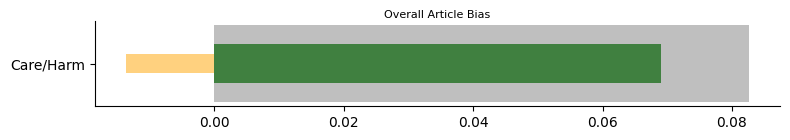
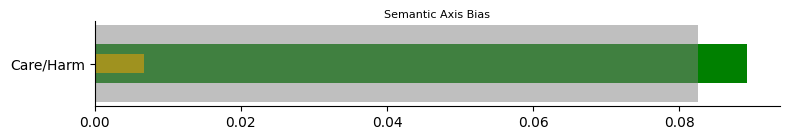
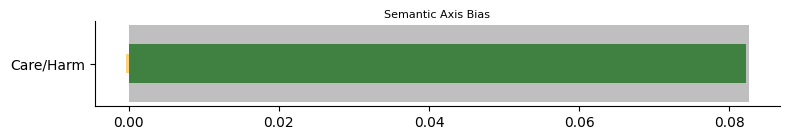
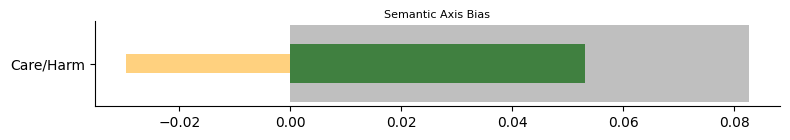
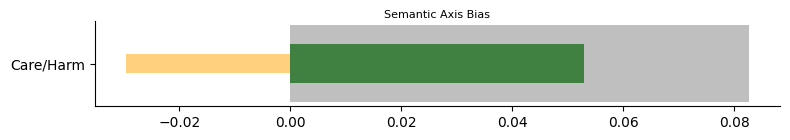
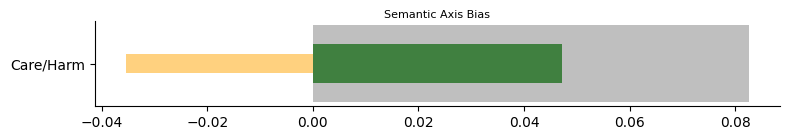
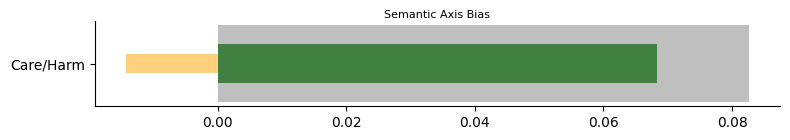
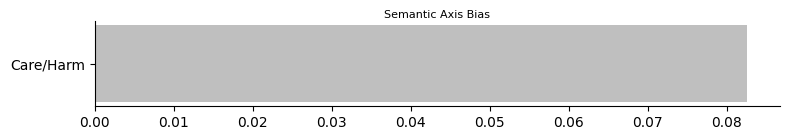
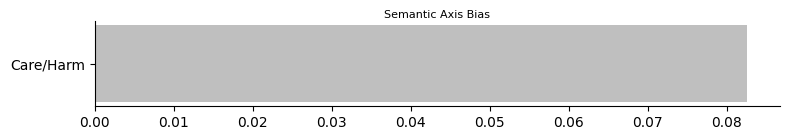
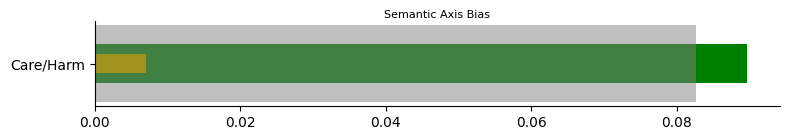
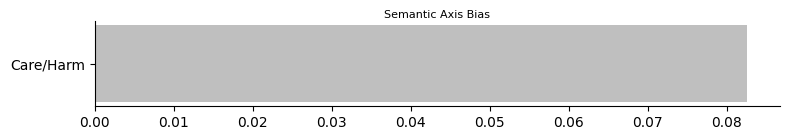
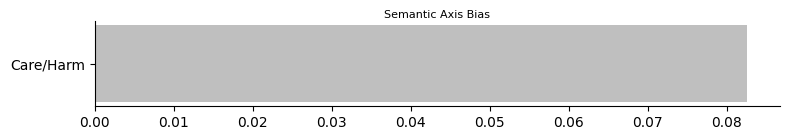
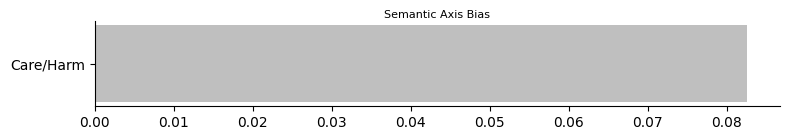
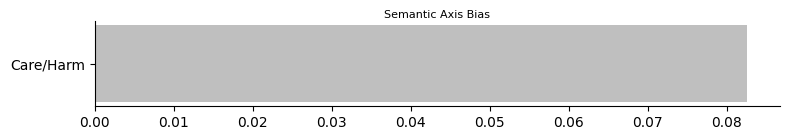
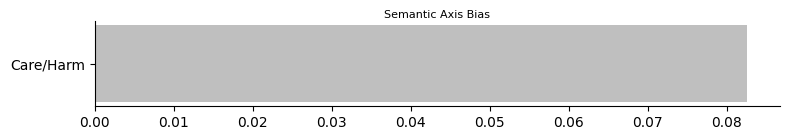
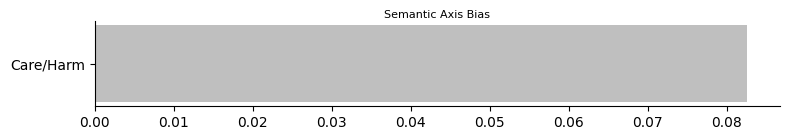
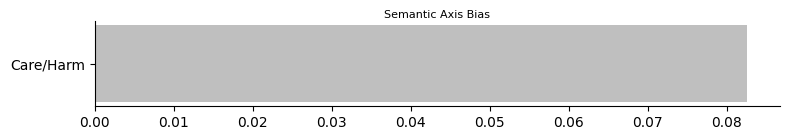
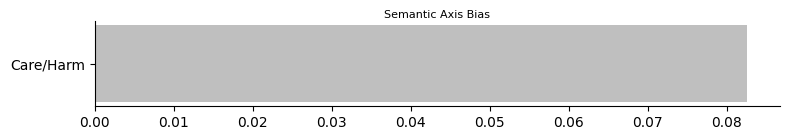
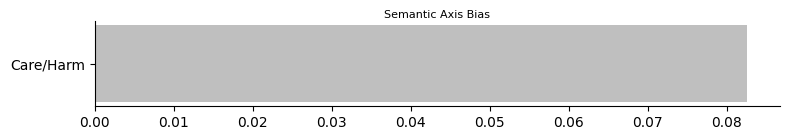
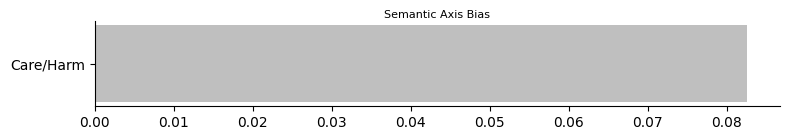
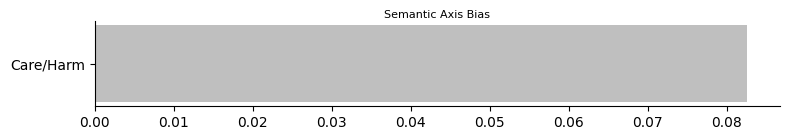
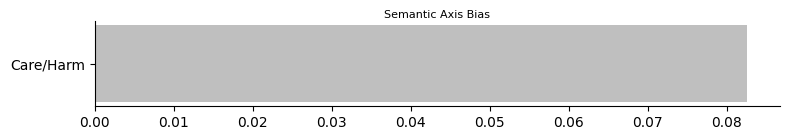
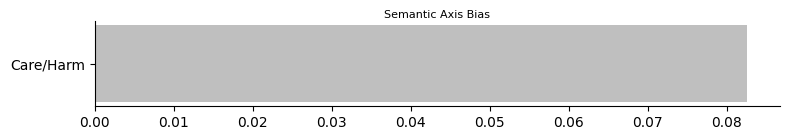
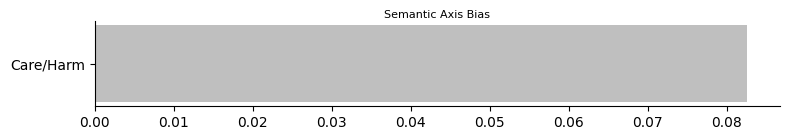
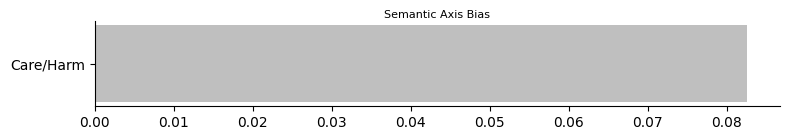

In [130]:
idx = 4 #2

# article id: IMM-10041
# frame: Legality, Constitutionality, Jurisdiction

article_data = evaluate_article(unsplit_dataset,
                                idx,
                                unsplit_used_labels_p_g,
                                unsplit_used_labels_a0_g,
                                unsplit_used_labels_a1_g,
                                unsplit_used_fx_d,
                                threshold_spans = 0.5)

# article_data, class_column_names, df_background_means, bias_to_plot, tokenizer, df_frameaxis_contributions, article_idx, ignore_helper_tokens=True
with np.errstate(invalid='ignore', divide='ignore', all="ignore"):
  visualize_article_bias_shifts(article_data, class_column_names, df_background_means, 'care_bias', tokenizer, articles_word_contributions[idx])

In [93]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.core.display import display, HTML
import base64
from io import BytesIO
import colorsys

def visualize_multiple_bias_shifts(article_data, class_column_names, df_background_means, biases_to_plot, sentence_range, tokenizer, word_contributions, ignore_helper_tokens=True):

    microframe_map = {
        "care": "Care/Harm",
        "loyalty": "Loyalty/Betrayal",
        "authority": "Authority/Subversion",
        "fairness": "Fairness/Cheating",
        "sanctity": "Sanctity/Degradation",
    }

    emoji_map = {
        "care": ("❤️", "💔"),
        "loyalty": ("🤝", "🔪"),
        "authority": ("👑", "🚫"),
        "fairness": ("⚖️", "🎲"),
        "sanctity": ("🕯️", "🚮"),
    }

    def get_emoji(bias_type, bias_value):
        positive_emoji, negative_emoji = emoji_map[bias_type.split('_')[0]]
        return positive_emoji if bias_value > 0 else negative_emoji

    def get_arrow_and_color(bias_value):
        if bias_value > 0.001:
            return "↑", "green"
        elif bias_value < -0.001:
            return "↓", "red"
        else:
            return "→", "orange"

    def create_plot(data, title, y_label, figsize=(8, 1.5)):  # Increased height
        fig, ax = plt.subplots(figsize=figsize)
        y = np.arange(len(data))

        bar_width = 0.2  # Increased bar width
        ax.barh(y, data['current_bias'], height=bar_width, color='green')
        ax.barh(y, data['background_bias'], height=bar_width*2, color='gray', alpha=0.5)
        ax.barh(y, data['difference'], height=bar_width/2, color='orange', alpha=0.5)

        ax.set_yticks(y)
        ax.set_yticklabels([y_label])  # Set y-label as the tick label
        ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
        ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(True)
        ax.spines['bottom'].set_visible(True)

        ax.set_title(title, fontsize=10, pad=5)

        plt.tight_layout()

        buf = BytesIO()
        plt.savefig(buf, format="png", bbox_inches="tight", dpi=100)  # Increased DPI for better quality
        buf.seek(0)
        img_str = base64.b64encode(buf.read()).decode("utf-8")
        plt.close(fig)

        max_width = figsize[0] * 100

        return f'<img src="data:image/png;base64,{img_str}" style="width:100%; max-width:{max_width}px; display:block; margin-bottom:20px;" alt="plot"/>'


    def calculate_combined_background_bias(df_background_means, predicted_frames, bias_type):
        relevant_frames = df_background_means[df_background_means['document_frame'].isin(predicted_frames)]
        background_col = f'background_{bias_type}'
        count_col = f'{bias_type}_background_count'

        total_count = relevant_frames[count_col].sum()
        weighted_sum = (relevant_frames[background_col] * relevant_frames[count_col]).sum()

        return weighted_sum / total_count if total_count > 0 else 0

    def get_color_for_bias(bias_value):
        if bias_value > 0:
            hue = 120 / 360
            saturation = min(abs(bias_value) * 2, 1)
            value = 1 - (saturation * 0.5)
        else:
            hue = 0
            saturation = min(abs(bias_value) * 2, 1)
            value = 1 - (saturation * 0.5)

        r, g, b = colorsys.hsv_to_rgb(hue, saturation, value)
        return f'rgb({int(r*255)}, {int(g*255)}, {int(b*255)})'

    def format_sentence_with_bias(sentence_text, word_contribs, bias_type, background_bias):
        formatted_words = []
        words = sentence_text.split()
        words_without_contrib = []

        for word in words:
            matching_contrib = next((contrib for contrib in word_contribs if contrib['word'].lower() == word.lower()), None)
            if matching_contrib:
                word_bias = matching_contrib[bias_type.split('_')[0]]
                relative_bias = word_bias - background_bias
                color = get_color_for_bias(relative_bias)
                formatted_word = f'<span style="background-color: {color};">{word}</span>'
            else:
                formatted_word = word
                words_without_contrib.append(word)

            formatted_words.append(formatted_word)

        return ' '.join(formatted_words), words_without_contrib

    bias_mapping = {
        'authority_bias': 0, 'authority_intensity': 1, 'care_bias': 2, 'care_intensity': 3,
        'fairness_bias': 4, 'fairness_intensity': 5, 'loyalty_bias': 6, 'loyalty_intensity': 7,
        'sanctity_bias': 8, 'sanctity_intensity': 9
    }

    microframe_map = {
        "care": "Care/Harm", "loyalty": "Loyalty/Betrayal", "authority": "Authority/Subversion",
        "fairness": "Fairness/Cheating", "sanctity": "Sanctity/Degradation",
    }

    overall_label_probs = article_data['label_probabilities']
    overall_labels = [class_column_names[i] for i, prob in enumerate(overall_label_probs) if prob > 0.5]
    proper_overall_labels = [label for label in overall_labels]

    valid_sentences = article_data['sentences'][sentence_range[0]-1:sentence_range[1]]

    # Create overall plots and info text
    overall_html = '<div style="border: 1px solid black; padding: 10px; margin-bottom: 20px; background-color: white; color: black;">'


    # Introduction text
    intro_text = ("This visualization analyzes the bias in text using moral foundation theory. "
                  "It shows how the text leans towards different moral dimensions both at the article and sentence level.")
    overall_html += f'<div style="margin-bottom: 15px;"><strong>Introduction:</strong> {intro_text}</div>'

    overall_html += f'<div><strong>Predicted Frames:</strong> {", ".join(proper_overall_labels)}</div><br>'

    # Info text and legend
    info_text = ("<strong>How to read this visualization:</strong><br>"
                 "1. Each moral dimension is represented by emojis and arrows:<br>")

    legend_html = '<div style="display: flex; flex-wrap: wrap; justify-content: space-between; margin-bottom: 15px;">'
    for bias_key, (pos_emoji, neg_emoji) in emoji_map.items():
        microframe_name = microframe_map[bias_key]
        legend_html += f'<div style="flex-basis: 30%; margin-bottom: 5px;"><strong>{microframe_name}:</strong> {pos_emoji}/{neg_emoji}</div>'
    legend_html += '</div>'

    info_text += (f"{legend_html}"
                  "2. Arrows indicate the bias direction: ↑ (green) towards first trait, ↓ (red) towards second trait, → (orange) neutral.<br>"
                  "3. In plots: <span style='display:inline-block; width:10px; height:10px; background-color: green; margin-right:5px;'></span> green = current article/sentence, "
                  "<span style='display:inline-block; width:10px; height:10px; background-color: gray; margin-right:5px;'></span> gray = background corpus, "
                  "<span style='display:inline-block; width:10px; height:10px; background-color: orange; margin-right:5px;'></span> orange = difference.<br>"
                  "4. Word colors in sentences indicate bias intensity (green = positive, red = negative).")

    overall_html += f'<div style="margin-bottom: 15px;">{info_text}</div>'

    # Create a container for vertical alignment of plots
    overall_html += '<div style="display: flex; flex-direction: column; align-items: center; width: 100%;">'

    for bias_to_plot in biases_to_plot:
        bias_key = bias_to_plot.split('_')[0]
        microframe_name = microframe_map.get(bias_key, bias_key.capitalize())

        combined_background_bias = calculate_combined_background_bias(df_background_means, overall_labels, bias_to_plot)

        all_bias_values = [frame['ids'][bias_mapping[bias_to_plot]]
                           for sentence in article_data['sentences']
                           for frame in sentence['fx']]
        article_bias = np.mean(all_bias_values)
        overall_difference = article_bias - combined_background_bias

        overall_plot_df = pd.DataFrame({
            'current_bias': [article_bias],
            'background_bias': [combined_background_bias],
            'difference': [overall_difference]
        }, index=[bias_to_plot])

        emoji = get_emoji(bias_to_plot, overall_difference)
        overall_plot_html = create_plot(overall_plot_df, f"Overall Article Bias - {microframe_name}", microframe_name, figsize=(9, 1))
        overall_html += f'<div style="width: 100%; heigth: 50px;">{overall_plot_html}</div>'

    overall_html += '</div>'  # Close the vertical alignment container
    overall_html += '</div>'  # Close overall div

    # Create HTML for sentence sections
    sentence_html = ""
    for i, sentence_data in enumerate(valid_sentences, sentence_range[0]):
        sentence_ids = sentence_data['sentence_ids']
        if ignore_helper_tokens:
            sentence_ids = [id for id in sentence_ids if id not in [0, 1, 2, 3]]
        sentence_text = tokenizer.decode(sentence_ids)

        sentence_html += f'<div style="border: 1px solid black; padding: 10px; margin-bottom: 20px; background-color: white; color: black;">'

        # Collect emojis for each microframe
        emojis_html = ""
        for bias_to_plot in biases_to_plot:
            bias_key = bias_to_plot.split('_')[0]
            sentence_bias = np.mean([frame['ids'][bias_mapping[bias_to_plot]] for frame in sentence_data['fx']])
            combined_background_bias = calculate_combined_background_bias(df_background_means, overall_labels, bias_to_plot)
            sentence_difference = sentence_bias - combined_background_bias
            emoji = get_emoji(bias_to_plot, sentence_difference)
            emojis_html += f' <span title="{microframe_map[bias_key]}" style="margin-right:5px;">{emoji}</span>'

        sentence_labels = [ class_column_names[item["label_id"]] for item in sentence_data['fx'] ]

        sentence_html += f'<strong>Sentence {i}</strong> - <strong>{emojis_html}</strong> <div style="gray">Frames: <i>{", ".join(sentence_labels)}</i></div><br><br>'

        for bias_to_plot in biases_to_plot:
            bias_key = bias_to_plot.split('_')[0]
            microframe_name = microframe_map.get(bias_key, bias_key.capitalize())

            combined_background_bias = calculate_combined_background_bias(df_background_means, overall_labels, bias_to_plot)

            formatted_sentence, _ = format_sentence_with_bias(
                sentence_text,
                word_contributions['word_contributions'],
                bias_to_plot,
                combined_background_bias
            )

            sentence_bias = np.mean([frame['ids'][bias_mapping[bias_to_plot]] for frame in sentence_data['fx']])
            sentence_difference = sentence_bias - combined_background_bias

            sentence_plot_df = pd.DataFrame({
                'current_bias': [sentence_bias],
                'background_bias': [combined_background_bias],
                'difference': [sentence_difference]
            }, index=[bias_to_plot])

            arrow, color = get_arrow_and_color(sentence_difference)
            sentence_plot_html = create_plot(sentence_plot_df, f"Semantic Axis Bias", microframe_name)

            # Create a row for each microframe
            sentence_html += '<div style="display: flex; margin-bottom: 20px;">'

            # Left side: Text
            sentence_html += '<div style="flex: 1; padding-right: 10px; border-right: 1px solid black;">'
            sentence_html += f'<h4 style="margin: 0; padding: 0; color: black;">{microframe_name} <span style="color:{color};">{arrow}</span></h4>'
            sentence_html += f'<div>{formatted_sentence}</div>'
            sentence_html += '</div>'

            # Right side: Plot
            sentence_html += '<div style="flex: 1; padding-left: 10px;">'
            sentence_html += sentence_plot_html
            sentence_html += '</div>'

            sentence_html += '</div>'  # Close the row

        sentence_html += '</div>'  # Close sentence container

    # Combine overall and sentence sections
    full_html = f'''
    <div style="font-family: Arial, sans-serif;">
        {overall_html}
        {sentence_html}
    </div>
    '''

    display(HTML(full_html))


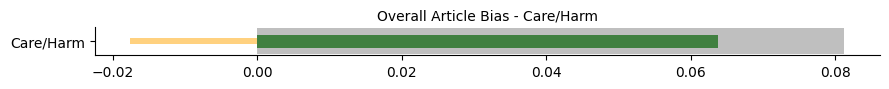
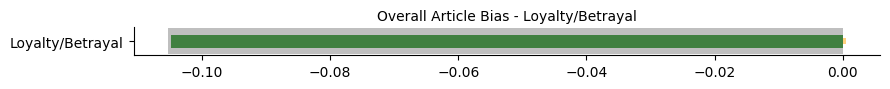
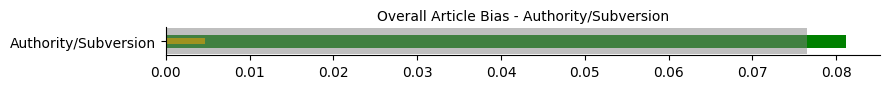
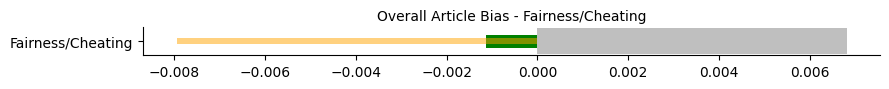
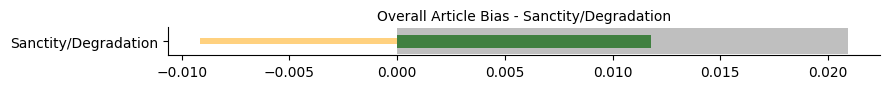
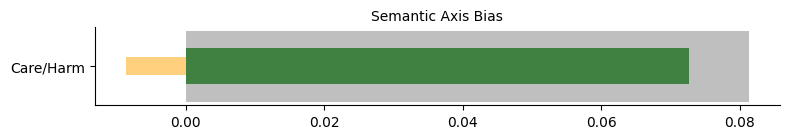
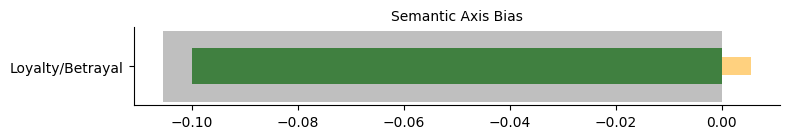
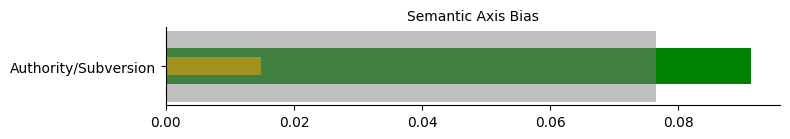
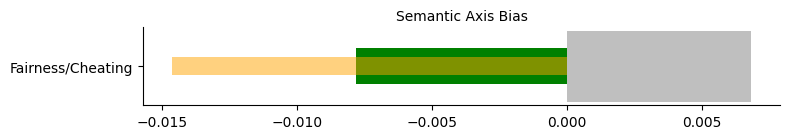
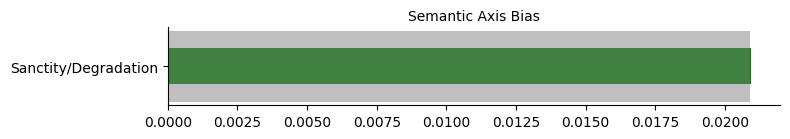
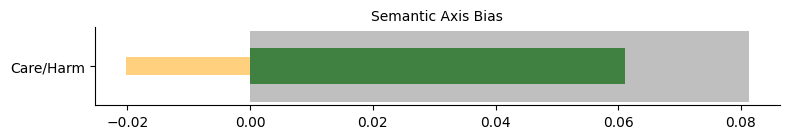
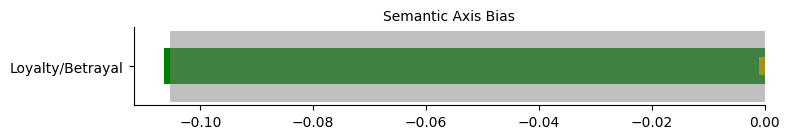
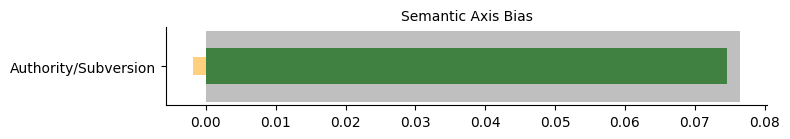
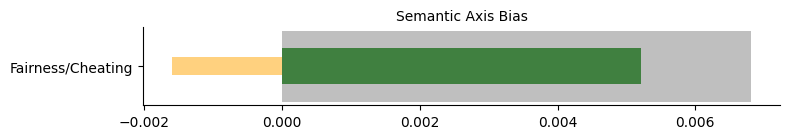
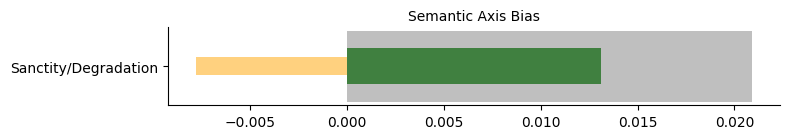

In [128]:
# Example usage:
idx = 32
biases_to_plot = ['care_bias', 'loyalty_bias', 'authority_bias', 'fairness_bias', 'sanctity_bias']
sentence_range = (2, 3)

# article id: IMM-10234
# frame: Fairness and Equality

article_data = evaluate_article(unsplit_dataset,
                                idx,
                                unsplit_used_labels_p_d,
                                unsplit_used_labels_a0_d,
                                unsplit_used_labels_a1_d,
                                unsplit_used_fx_d,
                                threshold_spans = 0.4)

visualize_multiple_bias_shifts(
    article_data,
    class_column_names,
    df_background_means,
    biases_to_plot,
    sentence_range,
    tokenizer,
    articles_word_contributions[idx],
    ignore_helper_tokens=True
)